# train_models

Train the face detection and landmark localisation models for Zeno's face based on our annotation.

## Step 1: Import models

In [1]:
import os
import cv2
import sys
import glob
import dlib
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zeno_face_tracker_helpers import *
try:
    from ConfigParser import ConfigParser    # If using Python 2.7
except ImportError:
    from configparser import ConfigParser    # If using Python 3.5
config = ConfigParser()
config.read('config.ini')
sys.path.append(os.path.realpath(config.get('zeno_interface', 'repository_path')))
from video_sources import *
from zeno_interface import *
sys.path.append(os.path.realpath(config.get('facial_landmark_tracker', 'repository_path')))
from ibug_face_tracker import *
print('All modules imported.')

All modules imported.


## Step 2: Load and prepare the dataset for face detection

In [2]:
# Load annotation and mete-data
train_set = pd.read_pickle(os.path.realpath(os.path.join('./dataset', 'train.pkl')))
test_set = pd.read_pickle(os.path.realpath(os.path.join('./dataset', 'test.pkl')))

# Load images and prepare the data structures
train_images = []
test_images = []
images = [train_images, test_images]
train_face_boxes = []
test_face_boxes = []
face_boxes = [train_face_boxes, test_face_boxes]
datasets = [train_set, test_set]
last_check_time = time.time()
for dataset_idx, dataset in enumerate(datasets):
    for idx in range(dataset.shape[0]):
        sample = dataset.iloc[idx]
        image_path = os.path.realpath(os.path.join('./dataset', sample['session'], 
                                                   '%06d.png' % sample['index']))
        images[dataset_idx].append(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY))
        face_boxes[dataset_idx].append([dlib.rectangle(sample['face_box'][0], sample['face_box'][1], 
                                                       sample['face_box'][0] + sample['face_box'][2] - 1, 
                                                       sample['face_box'][1] + sample['face_box'][3] - 1)])
        current_time = time.time()
        if last_check_time < current_time - 10.0:
            last_check_time = current_time
            print('%d training examples and %d test examples have been loaded.' % 
                  (len(train_images), len(test_images)))
print('All %d training examples and %d test examples have been loaded.' % 
      (len(train_images), len(test_images)))

343 training examples and 131 test examples have been loaded.
All 343 training examples and 172 test examples have been loaded.


## Step 3: Test dlib face detector on the test set

This is what dlib.test_simple_object_detector says:
precision: 1, recall: 0.732558, average precision: 0.732558
126 of 172 faces (0.007%) have been detected, with m-IOU=0.591.


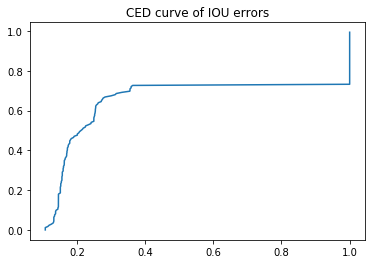

In [3]:
%matplotlib inline

# First test it on the test set
dlib_face_detector = dlib.get_frontal_face_detector()
print('This is what dlib.test_simple_object_detector says:')
print(dlib.test_simple_object_detector(test_images, test_face_boxes, dlib_face_detector))
not_detected = 0
ious = []
for idx in range(len(test_images)):
    detections = sorted([face for face in dlib_face_detector(test_images[idx])], 
                        key=dlib.rectangle.area, reverse=True)
    if len(detections) > 0:
        intersection = detections[0].intersect(test_face_boxes[idx][0]).area()
        union = dlib.rectangle(min(detections[0].left(), test_face_boxes[idx][0].left()), 
                               min(detections[0].top(), test_face_boxes[idx][0].top()), 
                               max(detections[0].right(), test_face_boxes[idx][0].right()), 
                               max(detections[0].bottom(), test_face_boxes[idx][0].bottom())).area()
        iou = float(intersection) / float(union)
    else:
        iou = 0.0
        not_detected += 1
    ious.append(iou)
print('%d of %d faces (%.3f%%) have been detected, with m-IOU=%.3f.' % 
      ((len(test_images) - not_detected), 
       len(test_images), 
       float(len(test_images) - not_detected) / float(len(test_images) * 100.0), 
       np.mean(ious)))
iou_errors = sorted([1.0 - x for x in ious])
plt.plot(iou_errors, np.arange(len(iou_errors)) / float(len(iou_errors)))
plt.title('CED curve of IOU errors')
plt.show()

## Step 4: Train a face detector for Zeno

In [100]:
config.read('config.ini')
options = dlib.simple_object_detector_training_options()
options.be_verbose = config.getboolean('simple_object_detector_training_options', 'be_verbose')
options.add_left_right_image_flips = config.getboolean('simple_object_detector_training_options', 
                                                       'add_left_right_image_flips')
options.num_threads = config.getint('simple_object_detector_training_options', 'num_threads')
options.detection_window_size = config.getint('simple_object_detector_training_options', 
                                              'detection_window_size')
options.C = config.getfloat('simple_object_detector_training_options', 'C')
options.epsilon = config.getfloat('simple_object_detector_training_options', 'epsilon')
options.upsample_limit = config.getint('simple_object_detector_training_options', 
                                       'upsample_limit')
options.nuclear_norm_regularization_strength = config.getfloat('simple_object_detector_training_options', 
                                                               'nuclear_norm_regularization_strength')

# face_detector = dlib.train_simple_object_detector(train_images, train_face_boxes, options)

face_detector = dlib.train_simple_object_detector(train_images + test_images, 
                                                  train_face_boxes + test_face_boxes, 
                                                  options)

face_detector_model_path = os.path.realpath(os.path.join('./models', 'zeno_face_detector.model'))
face_detector.save(face_detector_model_path)
print('Face detector model has been trained and saved to: ' + face_detector_model_path)

Face detector model has been trained and saved to: D:\hhj\zeno_face_tracker\models\zeno_face_detector.model


## Step 5: Test the trained face detector on the test set

This is what dlib.test_simple_object_detector says:
precision: 1, recall: 1, average precision: 1
172 of 172 faces (0.010%) have been detected, with m-IOU=0.817.


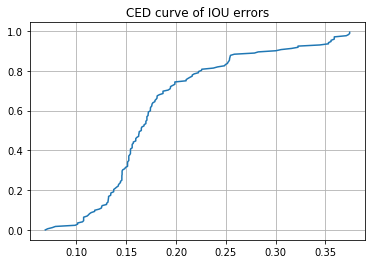

In [61]:
%matplotlib inline

# First test it on the test set
face_detector_model_path = os.path.realpath(os.path.join('./models', 'zeno_face_detector.model'))
face_detector = dlib.fhog_object_detector(face_detector_model_path)
print('This is what dlib.test_simple_object_detector says:')
print(dlib.test_simple_object_detector(test_images, test_face_boxes, face_detector))
not_detected = 0
ious = []
for idx in range(len(test_images)):
    detections = sorted([face for face in face_detector(test_images[idx])], 
                        key=dlib.rectangle.area, reverse=True)
    if len(detections) > 0:
        intersection = detections[0].intersect(test_face_boxes[idx][0]).area()
        union = dlib.rectangle(min(detections[0].left(), test_face_boxes[idx][0].left()), 
                               min(detections[0].top(), test_face_boxes[idx][0].top()), 
                               max(detections[0].right(), test_face_boxes[idx][0].right()), 
                               max(detections[0].bottom(), test_face_boxes[idx][0].bottom())).area()
        iou = float(intersection) / float(union)
    else:
        iou = 0.0
        not_detected += 1
    ious.append(iou)
print('%d of %d faces (%.3f%%) have been detected, with m-IOU=%.3f.' % 
      ((len(test_images) - not_detected), 
       len(test_images), 
       float(len(test_images) - not_detected) / float(len(test_images) * 100.0), 
       np.mean(ious)))
iou_errors = sorted([1.0 - x for x in ious])
plt.plot(iou_errors, np.arange(len(iou_errors)) / float(len(iou_errors)))
plt.title('CED curve of IOU errors')
plt.grid(which='both')
plt.show()

## Step 6: Prepare the dataset for landmark localisation (49 and 68 points)

In [24]:
images = [train_images, test_images]
train_landmarks_68 = []
test_landmarks_68 = []
landmarks68 = [train_landmarks_68, test_landmarks_68]
train_landmarks_49 = []
test_landmarks_49 = []
landmarks49 = [train_landmarks_49, test_landmarks_49]
face_detector_model_path = os.path.realpath(os.path.join('./models', 'zeno_face_detector.model'))
face_detector = dlib.fhog_object_detector(face_detector_model_path)
last_check_time = time.time()
for dataset_idx, dataset in enumerate(datasets):
    for idx in range(dataset.shape[0]):
        sample = dataset.iloc[idx]
        image = images[dataset_idx][idx]
        detections = sorted([face for face in face_detector(image)], 
                            key=dlib.rectangle.area, reverse=True)
        face_box = detections[0]
        pts68 = [dlib.point(int(round(pts[0])), int(round(pts[1]))) for pts in sample['landmarks']]
        pts49 = pts68[17:60] + pts68[61:64] + pts68[65:]
        landmarks68[dataset_idx].append([dlib.full_object_detection(face_box, pts68)])
        landmarks49[dataset_idx].append([dlib.full_object_detection(face_box, pts49)])
        current_time = time.time()
        if last_check_time < current_time - 10.0:
            last_check_time = current_time
            print('%d training examples and %d test examples have been prepared.' % 
                  (len(train_landmarks_49), len(test_landmarks_49)))
print('All %d training examples and %d test examples have been prepared.' % 
      (len(train_landmarks_49), len(test_landmarks_49)))

# Add left-right flipped examples
enhanced_train_images = train_images[:]
enhanced_test_images = test_images[:]
enhanced_images = [enhanced_train_images, enhanced_test_images]
flipped_indices_68 = (list(range(16, -1, -1)) + list(range(26, 16, -1)) + 
                      list(range(27, 31)) + list(range(35, 30, -1)) + 
                      [45, 44, 43, 42, 47, 46, 39, 38, 37, 36, 41, 40] + 
                      list(range(54, 47, -1)) + list(range(59, 54, -1)) + 
                      [64, 63, 62, 61, 60, 67, 66, 65])
flipped_indices_49 = (list(range(9, -1, -1)) + list(range(10, 14)) + list(range(18, 13, -1)) + 
                      [29, 27, 26, 25, 30, 29, 22, 21, 20, 19, 24, 23] + 
                      list(range(37, 30, -1)) + list(range(42, 37, -1)) + 
                      [45, 44, 43, 48, 47, 46])
for dataset_idx, image_set in enumerate(images):
    for idx, image in enumerate(image_set):
        face_box = landmarks68[dataset_idx][idx][0].rect
        flipped_face_box = dlib.rectangle(image.shape[1] - 1 - face_box.right(), face_box.top(), 
                                          image.shape[1] - 1 - face_box.left(), face_box.bottom())
        flipped_pts68 = [dlib.point(image.shape[1] - 1 - pts.x, pts.y) for 
                         pts in landmarks68[dataset_idx][idx][0].parts()]
        flipped_pts68 = [flipped_pts68[i] for i in flipped_indices_68]
        flipped_pts49 = [dlib.point(image.shape[1] - 1 - pts.x, pts.y) for 
                         pts in landmarks49[dataset_idx][idx][0].parts()]
        flipped_pts49 = [flipped_pts49[i] for i in flipped_indices_49]
        landmarks68[dataset_idx].append([dlib.full_object_detection(flipped_face_box, flipped_pts68)])
        landmarks49[dataset_idx].append([dlib.full_object_detection(flipped_face_box, flipped_pts49)])
        enhanced_images[dataset_idx].append(cv2.flip(image, 1))
print('Flipped examples have also been added.')

135 training examples and 0 test examples have been prepared.
261 training examples and 0 test examples have been prepared.
343 training examples and 53 test examples have been prepared.
All 343 training examples and 172 test examples have been prepared.
Flipped examples have also been added.


## Step 7: Train the shape predictors

In [73]:
config.read('config.ini')
suffixes = ['_68', '_49']
train_landmarks = [train_landmarks_68, train_landmarks_49]
for dataset_idx, landmarks in enumerate(train_landmarks):
    options = dlib.shape_predictor_training_options()
    options.be_verbose = config.getint('shape_predictor_training_options' + suffixes[dataset_idx], 
                                       'be_verbose')
    options.cascade_depth = config.getint('shape_predictor_training_options' + suffixes[dataset_idx], 
                                          'cascade_depth')
    options.tree_depth = config.getint('shape_predictor_training_options' + suffixes[dataset_idx], 
                                       'tree_depth')
    options.num_trees_per_cascade_level = config.getint('shape_predictor_training_options' + suffixes[dataset_idx], 
                                                        'num_trees_per_cascade_level')
    options.nu = config.getfloat('shape_predictor_training_options' + suffixes[dataset_idx], 'nu')
    options.oversampling_amount = config.getint('shape_predictor_training_options' + suffixes[dataset_idx], 
                                                'oversampling_amount')
    options.oversampling_translation_jitter = config.getfloat('shape_predictor_training_options' + 
                                                              suffixes[dataset_idx], 
                                                              'oversampling_translation_jitter')
    options.feature_pool_size = config.getint('shape_predictor_training_options' + suffixes[dataset_idx], 
                                              'feature_pool_size')
    options.lambda_param = config.getfloat('shape_predictor_training_options' + suffixes[dataset_idx], 
                                           'lambda_param')
    options.num_test_splits = config.getint('shape_predictor_training_options' + suffixes[dataset_idx], 
                                            'num_test_splits')
    options.feature_pool_region_padding = config.getfloat('shape_predictor_training_options' + 
                                                          suffixes[dataset_idx], 
                                                          'feature_pool_region_padding')
    options.num_threads = config.getint('shape_predictor_training_options' + suffixes[dataset_idx], 
                                        'num_threads')
    options.landmark_relative_padding_mode = config.getint('shape_predictor_training_options' + 
                                                           suffixes[dataset_idx], 
                                                           'landmark_relative_padding_mode')
    
#     shape_predictor = dlib.train_shape_predictor(enhanced_train_images, train_landmarks[dataset_idx], options)
    
    shape_predictor = dlib.train_shape_predictor(enhanced_train_images + enhanced_test_images, 
                                                 train_landmarks[dataset_idx] + test_landmarks[dataset_idx], 
                                                 options)
    
    shape_predictor_model_path = os.path.realpath(os.path.join(
        './models', 'zeno_landmark_tracker' + suffixes[dataset_idx] + '.model'))
    shape_predictor.save(shape_predictor_model_path)
    print('A shape predictor model has been trained and saved to: ' + shape_predictor_model_path)

A shape predictor model has been trained and saved to: D:\hhj\zeno_face_tracker\models\zeno_landmark_tracker_68.model
A shape predictor model has been trained and saved to: D:\hhj\zeno_face_tracker\models\zeno_landmark_tracker_49.model


## Step 8: Test the shape predictors on the test set

Shape predictors loaded.
Mean error for the 68 landmark model: 0.006807


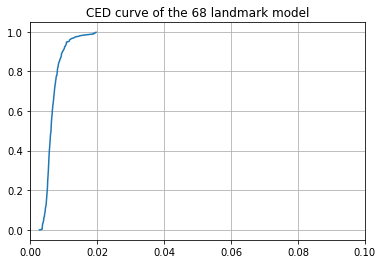

Mean error for the 68 landmark model on 49 landmarks: 0.006316


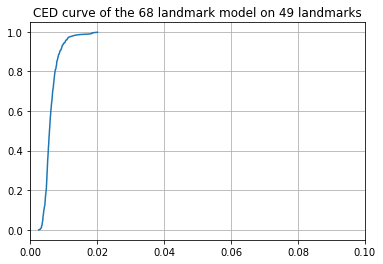

Mean error for the 49 landmark model: 0.005702


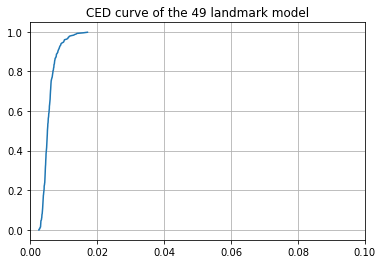

In [74]:
%matplotlib inline

def calculate_error(groundtruth, prediction):
    if groundtruth.shape[0] == 68:
        interocular_distance = np.linalg.norm(groundtruth[45] - groundtruth[36])
    elif groundtruth.shape[0] == 49:
        interocular_distance = np.linalg.norm(groundtruth[28] - groundtruth[19])
    else:
        interocular_distance = 1.0
    difference = prediction - groundtruth
    return np.mean([np.linalg.norm(x) for x in difference]) / interocular_distance


config.read('config.ini')
suffixes = ['_68', '_49']
shape_predictor_model_paths = [os.path.realpath(os.path.join(
    './models', 'zeno_landmark_tracker' + suffix + '.model')) for suffix in suffixes]
shape_predictors = [FaceTracker(model_path, os.path.realpath(config.get(
    'facial_landmark_tracker', 'auxiliary_model_path'))) for model_path in shape_predictor_model_paths]
for predictor in shape_predictors:
    predictor.eye_iterations = 0
    predictor.estimate_head_pose = False
    predictor.failure_detection_interval = 0
print('Shape predictors loaded.')

# Test the predictors
errors68 = []
errors68_49 = []
errors49 = []
test_landmarks = [test_landmarks_68, test_landmarks_49]
for predictor_idx, predictor in enumerate(shape_predictors):
    for idx, image in enumerate(enhanced_test_images):
        face_box = test_landmarks[predictor_idx][idx][0].rect
        predictor.track(image, (face_box.left(), face_box.top(), face_box.width(), face_box.height()))
        groundtruth = np.array([[pts.x for pts in test_landmarks[predictor_idx][idx][0].parts()], 
                                [pts.y for pts in test_landmarks[predictor_idx][idx][0].parts()]], dtype=float).T
        prediction = predictor.facial_landmarks
        error = calculate_error(groundtruth, prediction)
        if predictor_idx == 0:
            errors68.append(error)
        else:
            errors49.append(error)
        if groundtruth.shape[0] == 68:
            error49 = calculate_error(groundtruth[list(range(17, 60)) + list(range(61, 64)) + list(range(65, 68))], 
                                      prediction[list(range(17, 60)) + list(range(61, 64)) + list(range(65, 68))])
            errors68_49.append(error49)
print('Mean error for the 68 landmark model: %f' % np.mean(errors68))
plt.plot(sorted(errors68), np.arange(len(errors68)) / float(len(errors68)))
plt.title('CED curve of the 68 landmark model')
plt.grid(which='both')
plt.xlim(0.0, 0.1)
plt.show()
print('Mean error for the 68 landmark model on 49 landmarks: %f' % np.mean(errors68_49))
plt.plot(sorted(errors68_49), np.arange(len(errors68_49)) / float(len(errors68_49)))
plt.title('CED curve of the 68 landmark model on 49 landmarks')
plt.grid(which='both')
plt.xlim(0.0, 0.1)
plt.show()
print('Mean error for the 49 landmark model: %f' % np.mean(errors49))
plt.plot(sorted(errors49), np.arange(len(errors49)) / float(len(errors49)))
plt.title('CED curve of the 49 landmark model')
plt.grid(which='both')
plt.xlim(0.0, 0.1)
plt.show()